In [1]:
!pip install deepxde

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
import tensorflow as tf
from customnet import CumtomizedCartesianProd
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
print(dde.backend.backend_name)

tensorflow


In [4]:
# Load data from the first script
data_V = np.load('deeponet_data/V_data.npy')  # (900, 4000)
data_nm = np.load('deeponet_data/nmh_data.npy')  # (900, 4000, 7)
data_inf = np.load('deeponet_data/inf_data.npy')  # (900, 4000)
data_60alpha = np.load('deeponet_data/60alpha_data.npy')  # (60, 4000)

In [5]:
# Define time array
t = np.expand_dims(np.arange(0, 40, 0.01), 1)  # (4000, 1)

# Split the data into training and testing sets (e.g., 93% train, 7% test)
v_train1 = data_V[:280, :]
nm_train1 = data_nm[:280, :, :]
v_train2 = data_V[300:580, :]
nm_train2 = data_nm[300:580, :, :]
v_train3 = data_V[600:880, :]
nm_train3 = data_nm[600:880, :, :]

v_train = np.vstack((v_train1, v_train2, v_train3))
nm_train = np.vstack((nm_train1, nm_train2, nm_train3))

v_test1 = data_V[280:300, :]
nm_test1 = data_nm[280:300, :, :]
inf_test1 = data_inf[280:300, :3999]
v_test2 = data_V[580:600, :]
nm_test2 = data_nm[580:600, :, :]
inf_test2 = data_inf[580:600, :3999]
v_test3 = data_V[880:900, :]
nm_test3 = data_nm[880:900, :, :]
inf_test3 = data_inf[880:900, :3999]

v_test = np.vstack((v_test1, v_test2, v_test3))  # (60, 4000)
nm_test = np.vstack((nm_test1, nm_test2, nm_test3))  # (60, 4000, 7)
inf_test = np.vstack((inf_test1, inf_test2, inf_test3))  # (60, 3999)

# Normalize v_train and v_test
scaler_v = StandardScaler()
v_train_normalized = scaler_v.fit_transform(v_train)
v_test_normalized = scaler_v.transform(v_test)
# Normalize time input t
scaler_t = StandardScaler()
t_normalized = scaler_t.fit_transform(t)
# Normalize only the first three channels (non-one-hot part)
scaler_nm = StandardScaler()
nm_train_normalized_non_onehot = scaler_nm.fit_transform(nm_train[:, :, :3].reshape(-1, 3)).reshape(nm_train[:, :, :3].shape)
nm_test_normalized_non_onehot = scaler_nm.transform(nm_test[:, :, :3].reshape(-1, 3)).reshape(nm_test[:, :, :3].shape)
# Concatenate the normalized non-one-hot part with the original one-hot part
nm_train_normalized = np.concatenate([nm_train_normalized_non_onehot, nm_train[:, :, 3:]], axis=-1)
nm_test_normalized = np.concatenate([nm_test_normalized_non_onehot, nm_test[:, :, 3:]], axis=-1)


# Prepare inputs for DeepONet
nm_X_train = (v_train_normalized.astype(np.float32), t_normalized.astype(np.float32))
nm_y_train = nm_train_normalized.astype(np.float32)
nm_X_test = (v_test_normalized.astype(np.float32), t_normalized.astype(np.float32))
nm_y_test = nm_test_normalized.astype(np.float32)
print("dimension of nm_X_train[0]: ", nm_X_train[0].shape)
print("dimension of nm_y_train: ", nm_y_train.shape)
print("dimension of nm_X_test[0]: ", nm_X_test[0].shape)
print("dimension of nm_y_test: ", nm_y_test.shape)

# Data!!
data = dde.data.Triple(
    X_train=nm_X_train, y_train=nm_y_train, X_test=nm_X_test, y_test=nm_y_test
)

# Define layer sizes for both the branch and trunk networks
layer_sizes_branch = [4000, 512, 256, 128, 64, 30]
layer_sizes_trunk = [1, 64, 30]

# Define activation and kernel initializer
activation = "relu"
kernel_initializer = tf.keras.initializers.GlorotNormal()

# Network!!
net = CumtomizedCartesianProd(
    layer_sizes_branch=layer_sizes_branch,
    layer_sizes_trunk=layer_sizes_trunk,
    activation=activation,
    kernel_initializer=kernel_initializer,
    regularization=("l2", 1e-4),
    num_outputs=3,
    multi_output_strategy="split_both",
    activation_classifier=tf.keras.activations.softmax)


def custom_loss(y_true, y_pred):
    # Prediction loss (MSE) over all time steps and outputs
    prediction_loss = tf.reduce_mean(tf.square(y_true[:, :, :3] - y_pred[:, :, :3]))

    # Classification loss over all time steps
    y_true_indicator = y_true[:, :, 3:6]  # All time steps
    y_pred_indicator = y_pred[:, :, 3:6]  # All time steps

    # Flatten the last two dimensions to compute loss over all time steps and outputs
    y_true_indicator_flat = tf.reshape(y_true_indicator, [-1, y_true_indicator.shape[-1]])
    y_pred_indicator_flat = tf.reshape(y_pred_indicator, [-1, y_pred_indicator.shape[-1]])

    # Compute categorical cross-entropy directly without additional softmax
    classification_loss = tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(y_true_indicator_flat, y_pred_indicator_flat)
    )

    y_true_param_value = y_true[:, :, 6]  # True param values
    y_pred_param_value = y_pred[:, :, 6]  # Predicted param values
    param_value_loss = tf.reduce_mean(tf.square(y_true_param_value - y_pred_param_value))

    # Introduce weighting factors
    alpha = 15.0  # Weight for prediction loss
    beta = 1.0   # Weight for classification loss
    gamma = 0.2  # Weight for parameter value loss

    total_loss = alpha * prediction_loss + beta * classification_loss + gamma * param_value_loss
    return total_loss


def diff(g1, g2, alpha, dt):
    return g1/(1-(g2-g1)/(alpha*dt))


def mean_l2_relative_error(y_true, y_pred):
    # Compute per-sample relative errors over all time steps and outputs
    numerator = tf.norm(y_true - y_pred, axis=[1, 2])
    denominator = tf.norm(y_true, axis=[1, 2]) + 1e-8  # Avoid division by zero
    return tf.reduce_mean(numerator / denominator)


# Using gradient clipping
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=4000,
    decay_rate=0.5
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)


# Model!
model = dde.Model(data, net)
checkpoint_path = "trained_deeponet_model.h5-2000.ckpt"
model.restore(checkpoint_path)

# Model.compile!
model.compile(opt, loss=custom_loss, metrics=[mean_l2_relative_error])

# Model.train!
losshistory, train_state = model.train(epochs=100, display_every=10)


# Visualize!
xxx = model.predict(nm_X_test)  # (60, 4000, 7)

inf_prediction = np.zeros((60, 3999))
for i in range(60):
    for j in range(3999):
        inf_prediction[i, j] = diff(xxx[i, j, 0], xxx[i, j+1, 0], data_60alpha[i, j], 0.01)


# Calculate MSE and R-square for xxx[:, :, :3] and nm_y_test[:, :, :3]
mse_list = []
r2_list = []
for i in range(3):
    mse = mean_squared_error(nm_y_test[:, :, i].flatten(), xxx[:, :, i].flatten())
    r2 = r2_score(nm_y_test[:, :, i].flatten(), xxx[:, :, i].flatten())
    mse_list.append(mse)
    r2_list.append(r2)
print("MSE for [n, m, h]:", mse_list)
print("R-square for [n, m, h]:", r2_list)

# Calculate MSE and R-square for parameter values
param_value_mse = mean_squared_error(nm_y_test[:, :, 6].flatten(), xxx[:, :, 6].flatten())
param_value_r2 = r2_score(nm_y_test[:, :, 6].flatten(), xxx[:, :, 6].flatten())
print("MSE for parameter values:", param_value_mse)
print("R-square for parameter values:", param_value_r2)

# Convert one-hot encoded labels to class labels
nm_y_test_classes = np.argmax(nm_y_test[:, :, 3:6], axis=-1).flatten()  # (60, 4000) before flatten
xxx_classes = np.argmax(xxx[:, :, 3:6], axis=-1).flatten()  # (60, 4000) before flatten

# Calculate F1 score and accuracy
f1 = f1_score(nm_y_test_classes, xxx_classes, average='weighted')
accuracy = accuracy_score(nm_y_test_classes, xxx_classes)

print("F1 score for indicator:", f1)
print("Accuracy for indicator:", accuracy)

# Calculate MSE and R-square for inf_test and inf_prediction
inf_mse_list = []
inf_r2_list = []
inf_mse = mean_squared_error(inf_test[:, :].flatten(), inf_prediction[:, :].flatten())
inf_r2 = r2_score(inf_test[:, :].flatten(), inf_prediction[:, :].flatten())
inf_mse_list.append(inf_mse)
inf_r2_list.append(inf_r2)
print("MSE for inf_test and inf_prediction:", inf_mse_list)
print("R-square for inf_test and inf_prediction:", inf_r2_list)

dimension of nm_X_train[0]:  (840, 4000)
dimension of nm_y_train:  (840, 4000, 7)
dimension of nm_X_test[0]:  (60, 4000)
dimension of nm_y_test:  (60, 4000, 7)
Compiling model...
'compile' took 0.000246 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.37e+01]    [7.29e+01]    [1.05e+00]    
10        [8.29e-01]    [1.48e+00]    [9.48e-02]    
20        [4.21e-01]    [3.92e-01]    [5.54e-02]    
30        [2.53e-01]    [2.45e-01]    [4.41e-02]    
40        [2.32e-01]    [2.13e-01]    [4.26e-02]    
50        [2.21e-01]    [2.09e-01]    [3.97e-02]    
60        [2.06e-01]    [1.90e-01]    [3.58e-02]    
70        [2.01e-01]    [1.94e-01]    [3.54e-02]    
80        [1.96e-01]    [1.87e-01]    [3.44e-02]    
90        [1.95e-01]    [1.89e-01]    [3.42e-02]    
100       [1.90e-01]    [1.81e-01]    [3.36e-02]    

Best model at step 100:
  train loss: 1.90e-01
  test loss: 1.81e-01
  test metric: [3.36e-02]

'train' took 122.678351 s

MSE for [n, m, 

the first predict indicator is: [1.0000000e+00 2.3352367e-09 6.0497445e-12]
the first real indicator is: [1. 0. 0.]
the first predicted parameter value is: 2.8660853e-07
the first real parameter value is: 0.0


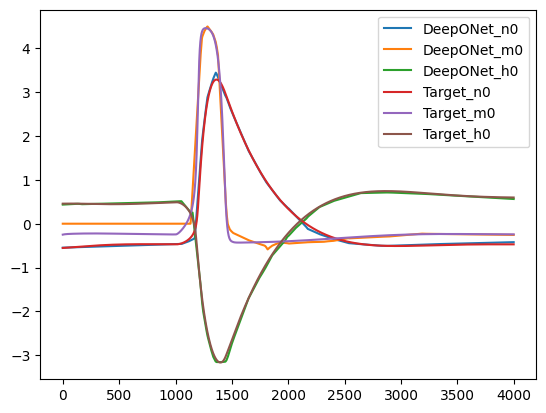

<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure()
prediction = xxx[0]
n = prediction[:, 0]
m = prediction[:, 1]
h = prediction[:, 2]
target = nm_y_test[0]
n_real = target[:, 0]
m_real = target[:, 1]
h_real = target[:, 2]
print("the first predict indicator is:", prediction[0, 3:6])
print("the first real indicator is:", target[0, 3:6])
print("the first predicted parameter value is:", prediction[0, 6])
print("the first real parameter value is:", target[0, 6])
plt.plot(n, label='DeepONet_n0')
plt.plot(m, label='DeepONet_m0')
plt.plot(h, label='DeepONet_h0')
plt.plot(n_real, label='Target_n0')
plt.plot(m_real, label='Target_m0')
plt.plot(h_real, label='Target_h0')
plt.legend()
plt.savefig('deeponet_images/prediction_plot.png')  # Save the image
plt.show()
plt.clf()

the second predict indicator is: [2.5046729e-10 9.9967003e-01 3.3002277e-04]
the second real indicator is: [0. 1. 0.]
the second predicted parameter value is: 98.568535
the second real parameter value is: 99.30511


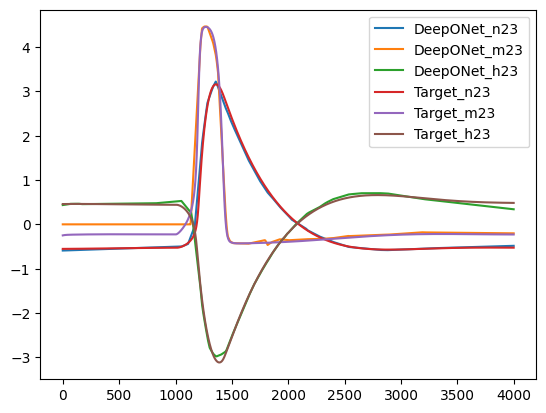

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure()
prediction2 = xxx[23]
n2 = prediction2[:, 0]
m2 = prediction2[:, 1]
h2 = prediction2[:, 2]
target2 = nm_y_test[23]
n2_real = target2[:, 0]
m2_real = target2[:, 1]
h2_real = target2[:, 2]
print("the second predict indicator is:", prediction2[0, 3:6])
print("the second real indicator is:", target2[0, 3:6])
print("the second predicted parameter value is:", prediction2[0, 6])
print("the second real parameter value is:", target2[0, 6])
plt.plot(n2, label='DeepONet_n23')
plt.plot(m2, label='DeepONet_m23')
plt.plot(h2, label='DeepONet_h23')
plt.plot(n2_real, label='Target_n23')
plt.plot(m2_real, label='Target_m23')
plt.plot(h2_real, label='Target_h23')
plt.legend()
plt.savefig('deeponet_images/prediction_plot2.png')  # Save the image
plt.show()
plt.clf()

the third predict indicator is: [4.0719496e-14 2.2435231e-09 1.0000000e+00]
the third real indicator is: [0. 0. 1.]
the third predicted parameter value is: 30.279251
the third real parameter value is: 30.165974


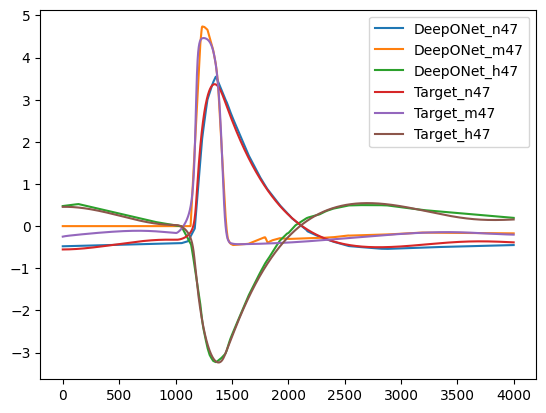

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure()
prediction3 = xxx[47]
n3 = prediction3[:, 0]
m3 = prediction3[:, 1]
h3 = prediction3[:, 2]
target3 = nm_y_test[47]
n3_real = target3[:, 0]
m3_real = target3[:, 1]
h3_real = target3[:, 2]
print("the third predict indicator is:", prediction3[0, 3:6])
print("the third real indicator is:", target3[0, 3:6])
print("the third predicted parameter value is:", prediction3[0, 6])
print("the third real parameter value is:", target3[0, 6])
plt.plot(n3, label='DeepONet_n47')
plt.plot(m3, label='DeepONet_m47')
plt.plot(h3, label='DeepONet_h47')
plt.plot(n3_real, label='Target_n47')
plt.plot(m3_real, label='Target_m47')
plt.plot(h3_real, label='Target_h47')
plt.legend()
plt.savefig('deeponet_images/prediction_plot3.png')  # Save the image
plt.show()
plt.clf()